In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_pipeline import transformation_pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:

data = pd.read_csv('content/preprocessed_train.csv')

# let's pick the data wiht primary_use==0
data = data.query('primary_use==0 & meter==0')

In [3]:
b_id = [118, 646, 125]

In [16]:
def plot_output(actual, predicted, title, building_idx, avg_loss, avg_rmse):
    fig, (ax1, ax2, ax) = plt.subplots(3, 1,  figsize=(30, 15), sharex=True)

    fig.suptitle(
        f'{title} model for building {building_idx}\nmse={avg_loss:.5f}\nrmse={avg_rmse:.5f}', fontsize=24)

    ax1.plot(range(len(actual)),
             predicted,
             color='green', linestyle='dashed')
    ax1.set_title('Predicted')
    ax1.set_ylim(0, 1)

    ax2.plot(range(len(actual)),
             actual,
             color='red', label='Actual')
    ax2.set_title('Actual')
    ax2.set_ylim(0, 1)

    ax.plot(range(len(actual)),
            predicted,
            color='green', linestyle='dashed',
            label='Predicted')

    ax.plot(range(len(actual)),
            actual,
            color='red',
            label='actual')
    ax.set_ylim(0, 1)
    plt.legend()
    plt.show()
    fig.savefig(
        f'Final Plots for the research/train on 70 until best/{title} model -- building {building_idx} -- mse {avg_loss:.5f} -- rmse {avg_rmse:.5f}.png')

# %%

# function to laod certain building id


def loading_data(idx, train_size):
    pipeline, data_cleaned = transformation_pipeline(
        data, building_id=idx, meter=0, primary_use=0)

    train, test = train_test_split(data_cleaned,
                                   # [:, 1:],
                                   #transformed_data[:, 0],
                                   train_size=train_size,
                                   shuffle=False,
                                   random_state=2021)

    train_data = pipeline.fit_transform(train)
    test_data = pipeline.transform(test)

    x_train, y_train = train_data[:, 1:], train_data[:, 0]

    x_val, y_val = test_data[:, 1:], test_data[:, 0]

    train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train,
                                                                    y_train,
                                                            length=6, sampling_rate=1,
                                                             stride=1,
                                                             batch_size=32,
                                                                shuffle=False)

    val_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_val,
                                                                  y_val,
                                                      length=6, sampling_rate=1,
                                                      stride=1, batch_size=350,
                                                      shuffle=False
                                                      )
    return train_gen, val_gen[0]

In [5]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

# %% function to return models

from tensorflow.keras import layers
def create_model(model_name):
    if model_name == 'gru':
        model = tf.keras.Sequential([tf.keras.layers.GRU(128, activation='relu',
                                                         return_sequences=False),
                                     tf.keras.layers.Dense(1)])
    elif model_name == 'lstm':

        model = tf.keras.Sequential([tf.keras.layers.LSTM(128, activation='relu',
                                                          return_sequences=False),
                                     tf.keras.layers.Dense(1)])
    elif model_name == 'rnn':

        model = tf.keras.Sequential([tf.keras.layers.SimpleRNN(128, activation='relu',
                                                      return_sequences=False),
                                 tf.keras.layers.Dense(1)])
    elif model_name == 'transformer':
        model = build_model(
            (6, 14),  # 6 is for the window on our data 6 hours, and 11 for the features
            head_size=256,  # play with this
            num_heads=8,  # and this
            ff_dim=128,  # and this
            num_transformer_blocks=1,  # and this
            mlp_units=[256],
            mlp_dropout=0.0,
            dropout=0.0,
        )

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.0001))
    return model

C:\Users\shomer\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\shomer\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\projects\Research-Buildings-Energy-forecasting-using-Deep-Learning\data_fetcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

model Transformer took 320.84852409362793 seconds


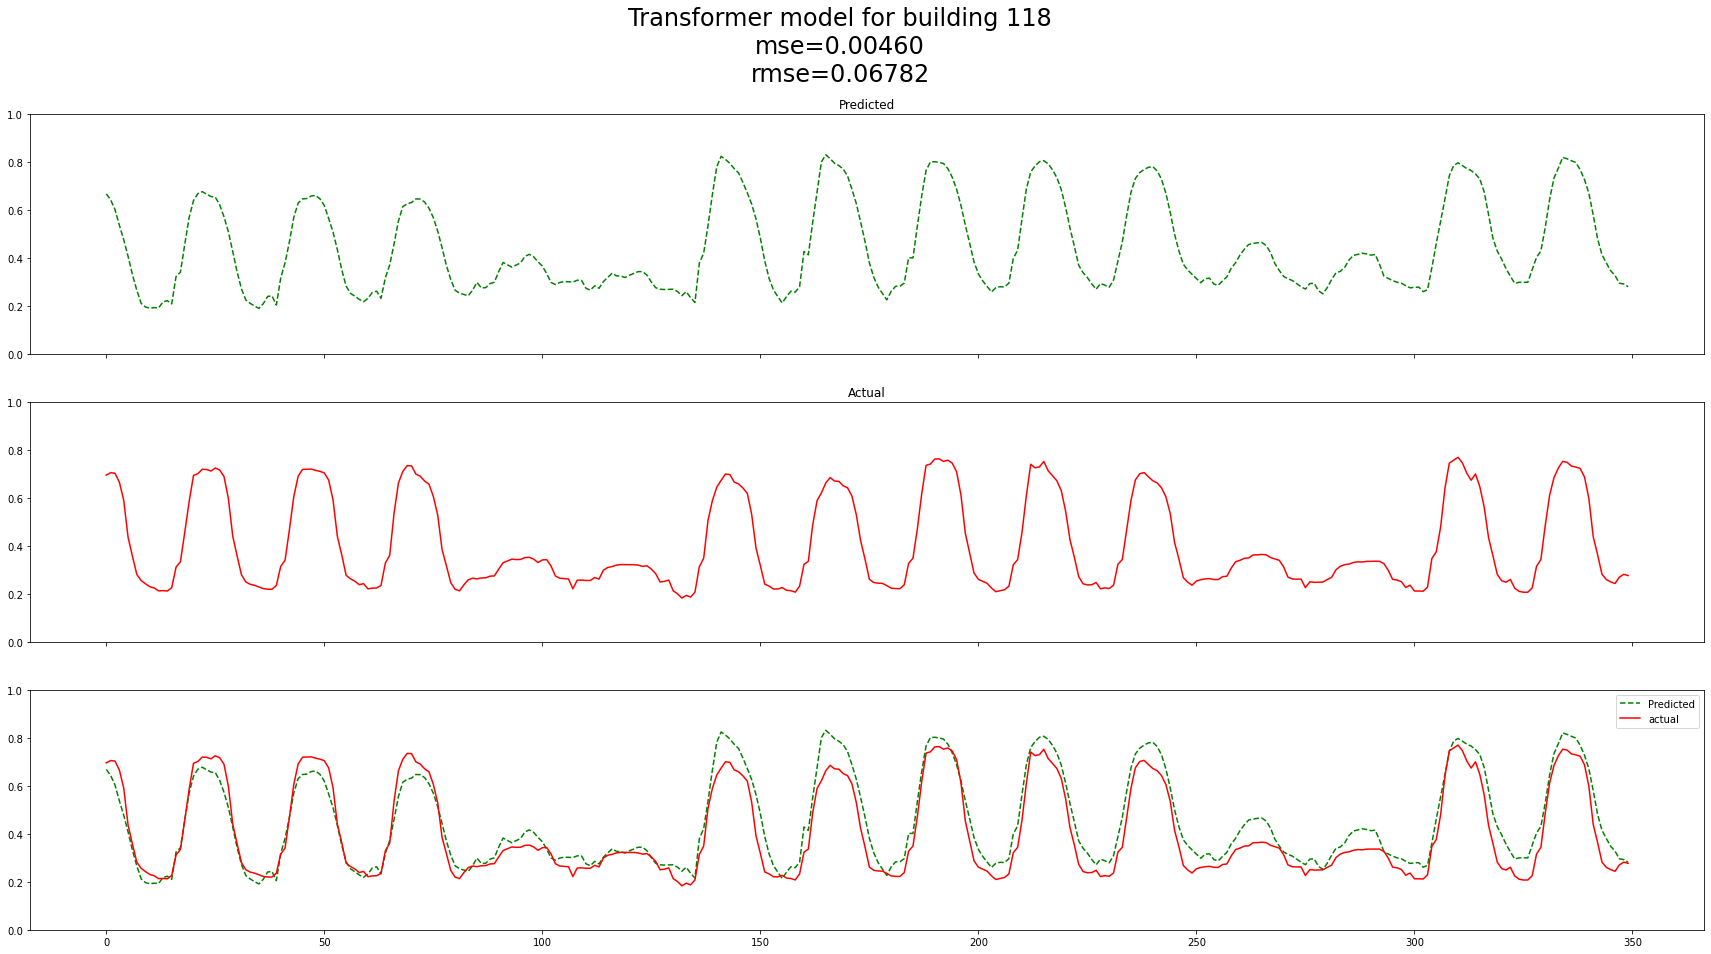

model GRU took 117.57561445236206 seconds


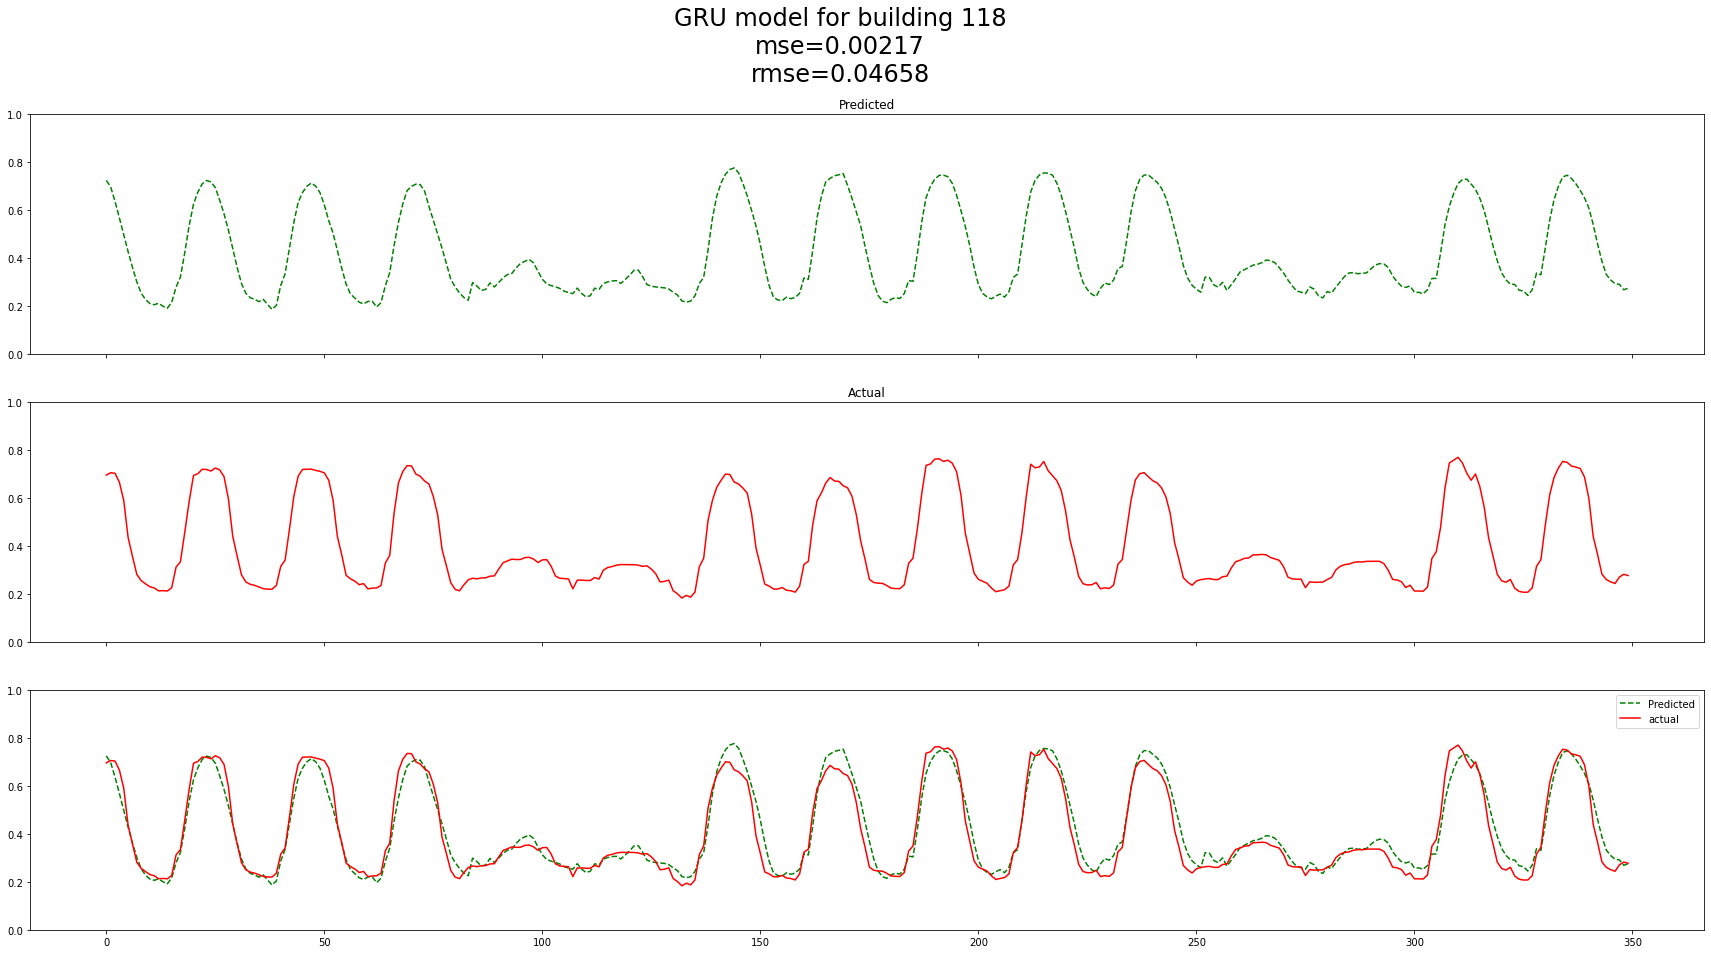

model LSTM took 147.77776312828064 seconds


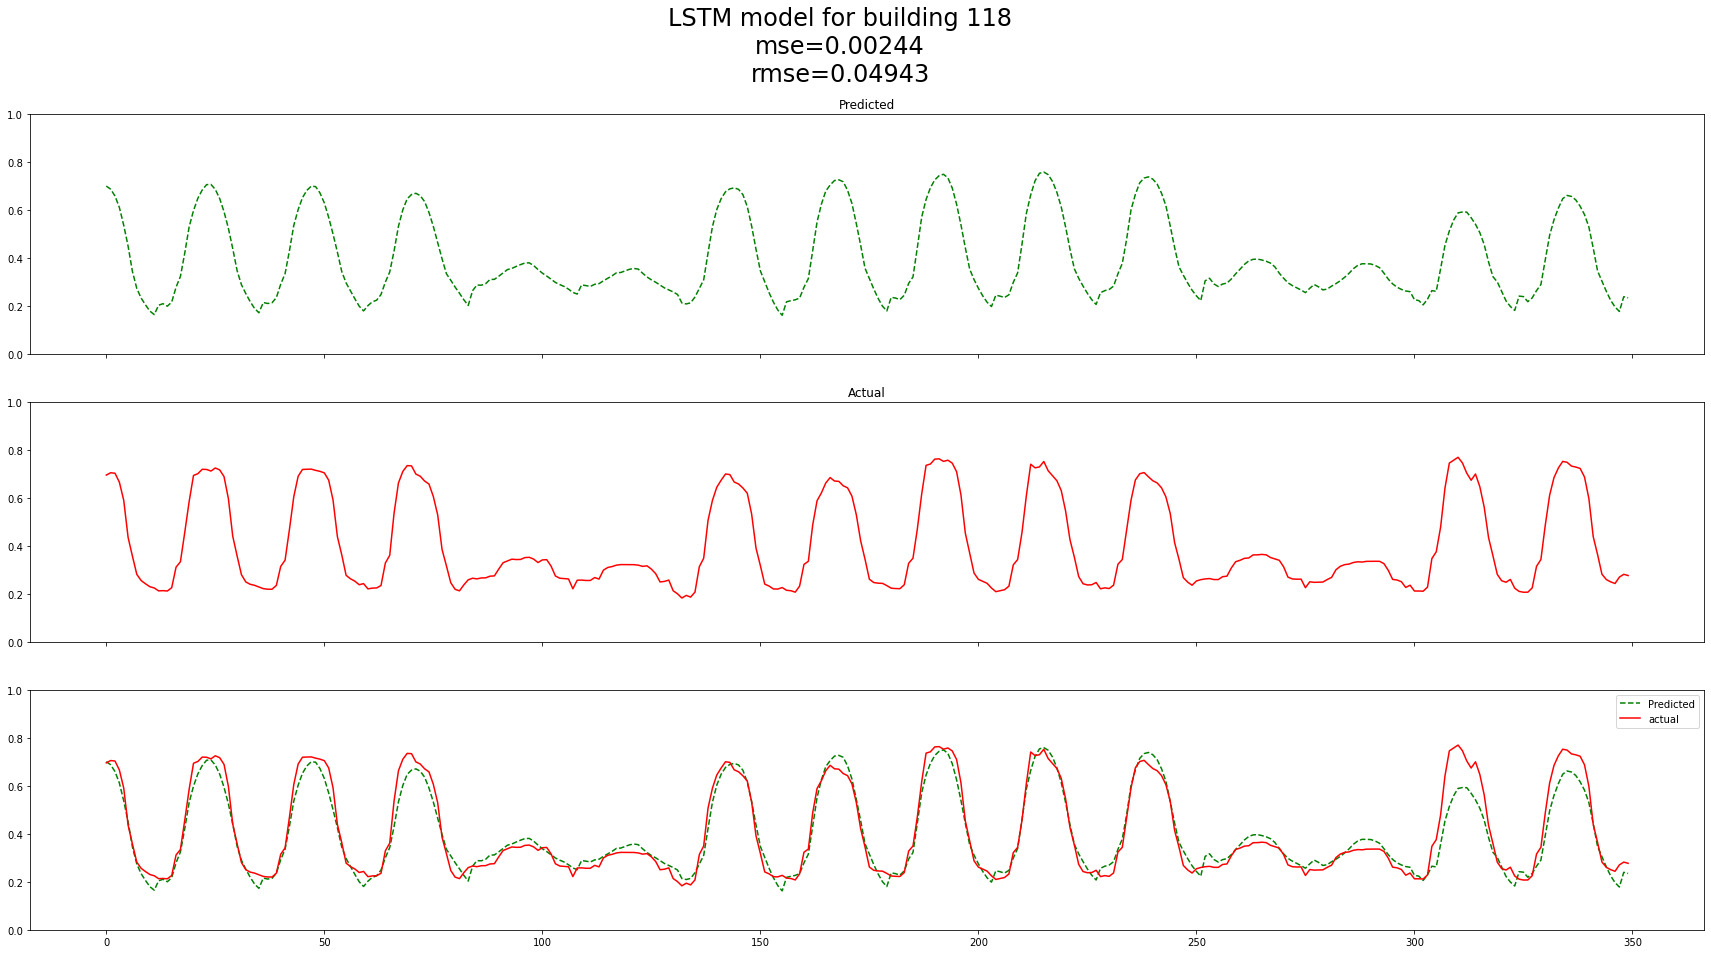

model RNN took 45.680992603302 seconds


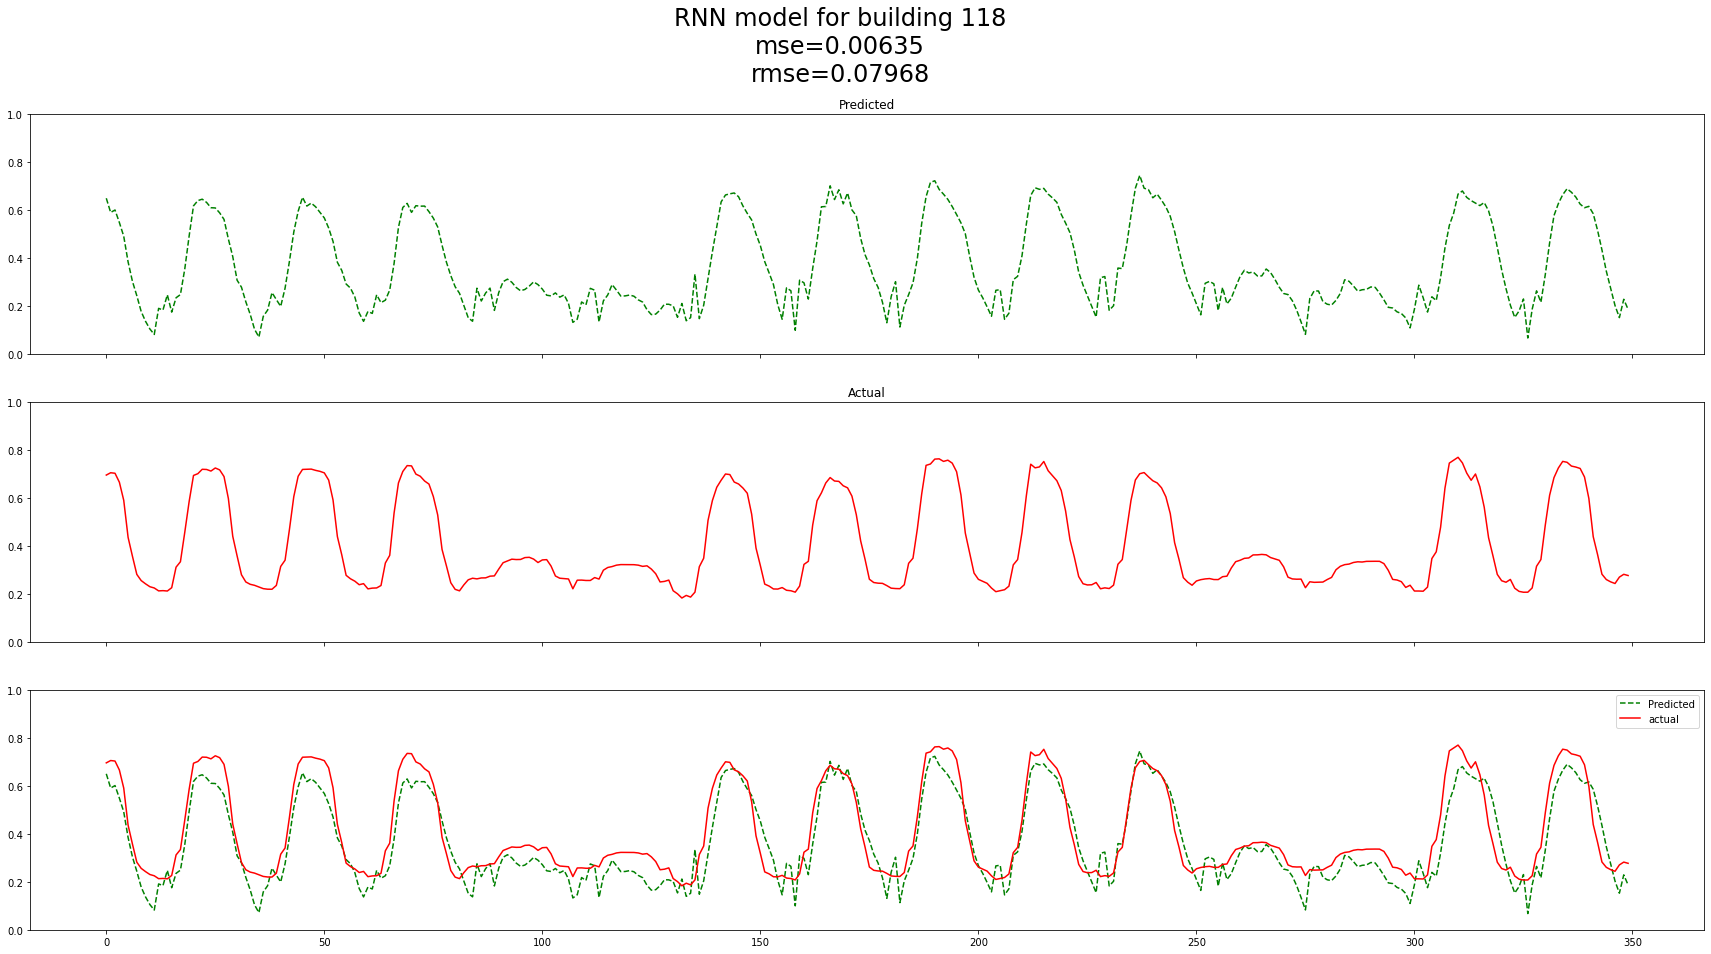

C:\Users\shomer\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\shomer\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\projects\Research-Buildings-Energy-forecasting-using-Deep-Learning\data_fetcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

model Transformer took 378.1816370487213 seconds


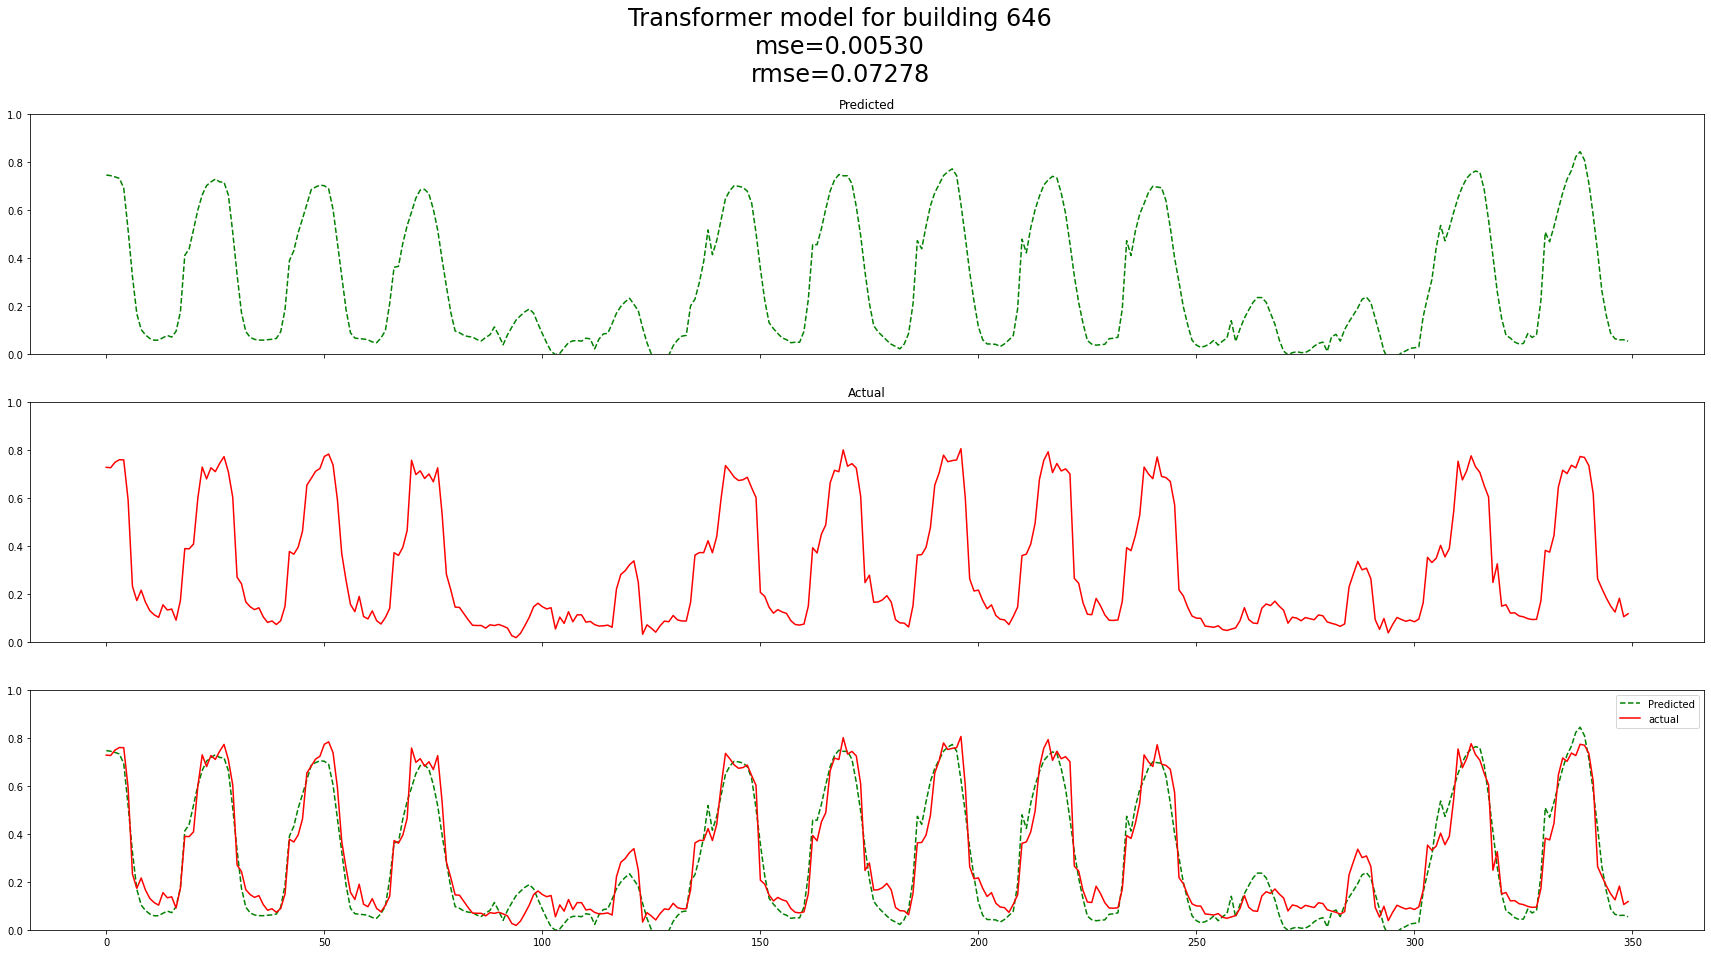

model GRU took 105.86662817001343 seconds


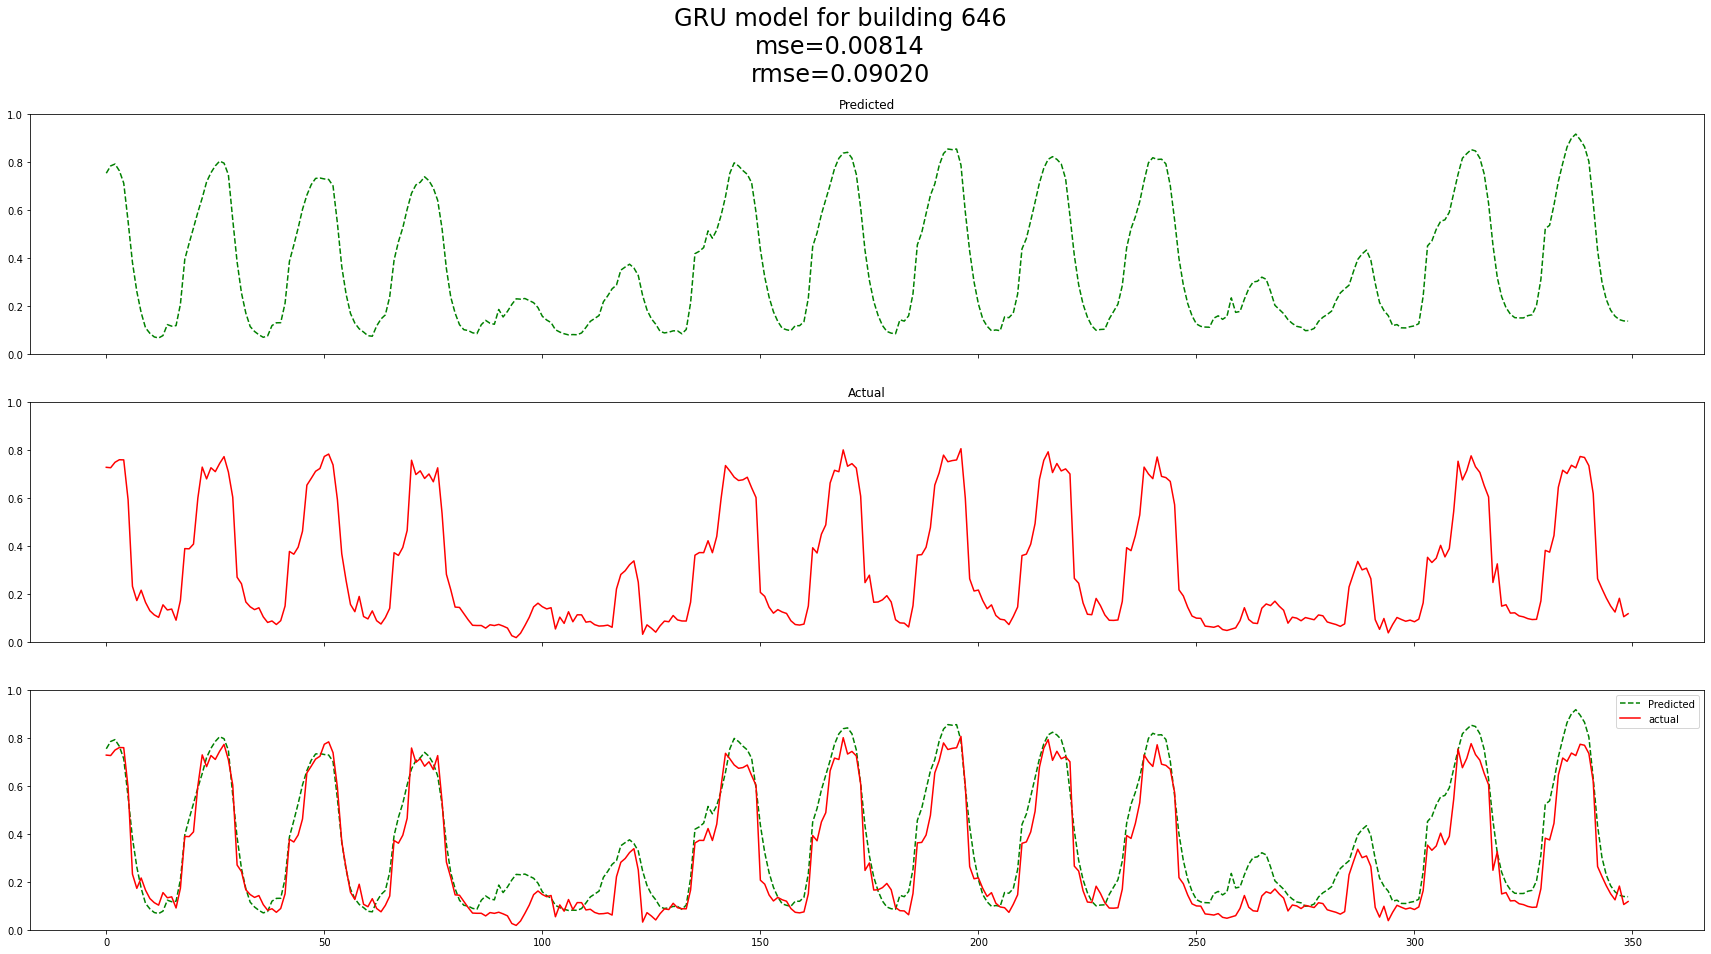

model LSTM took 139.78003597259521 seconds


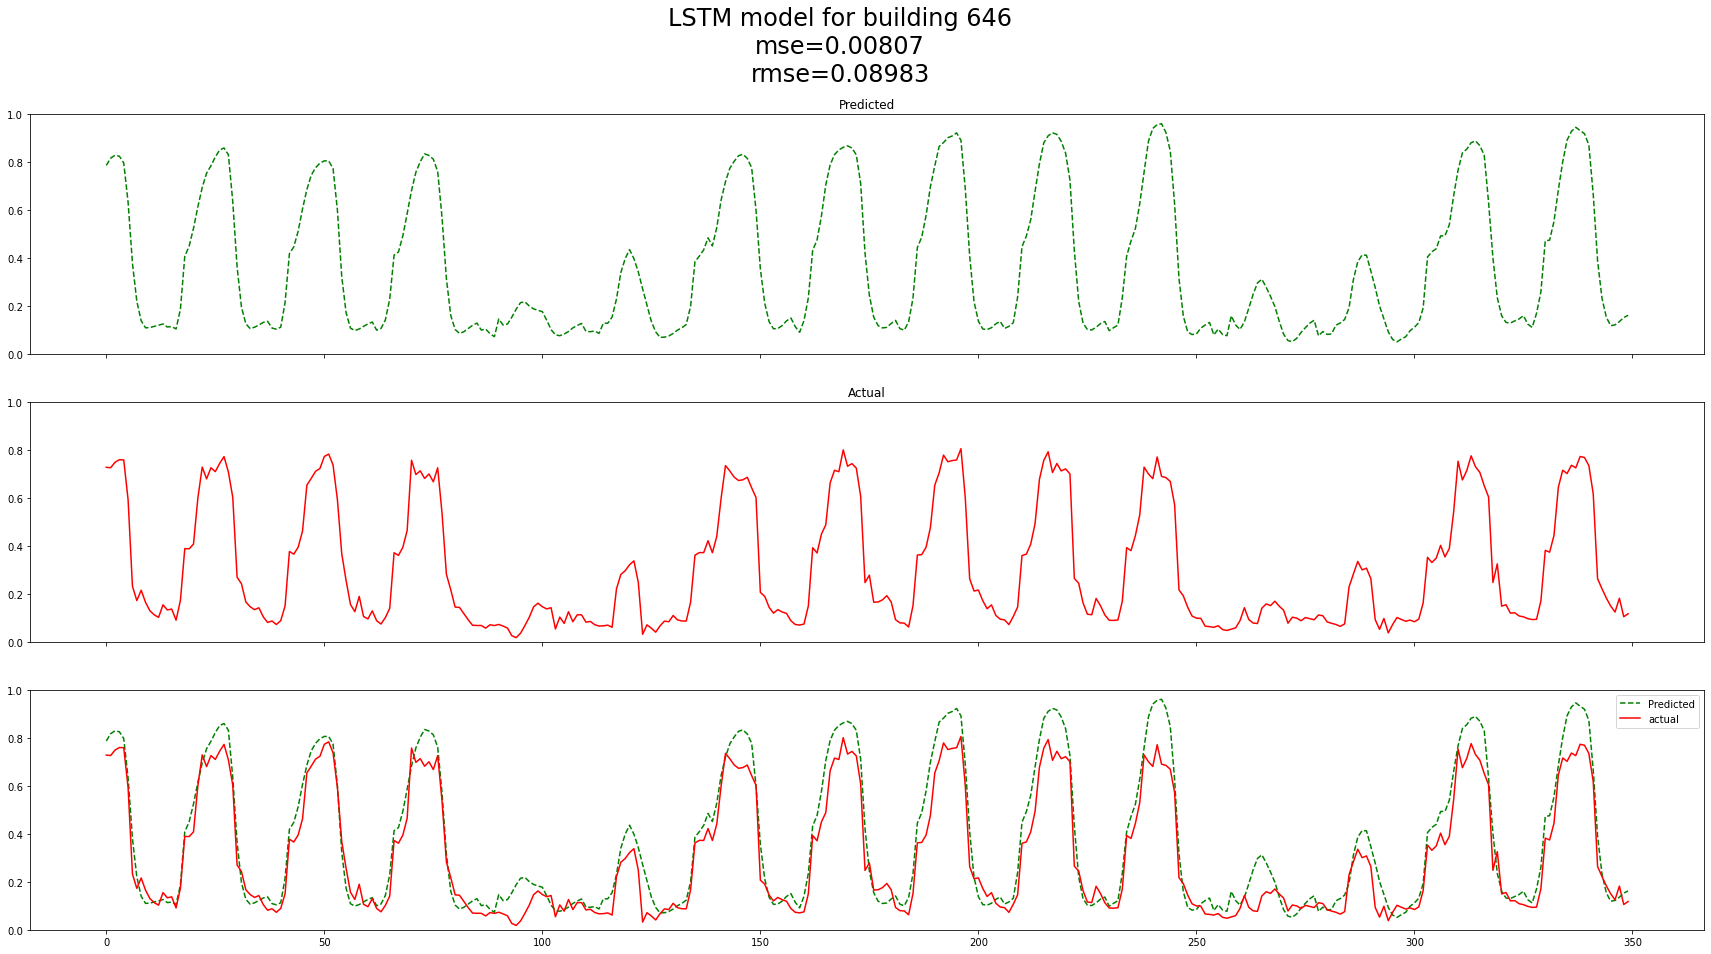

model RNN took 39.98264837265015 seconds


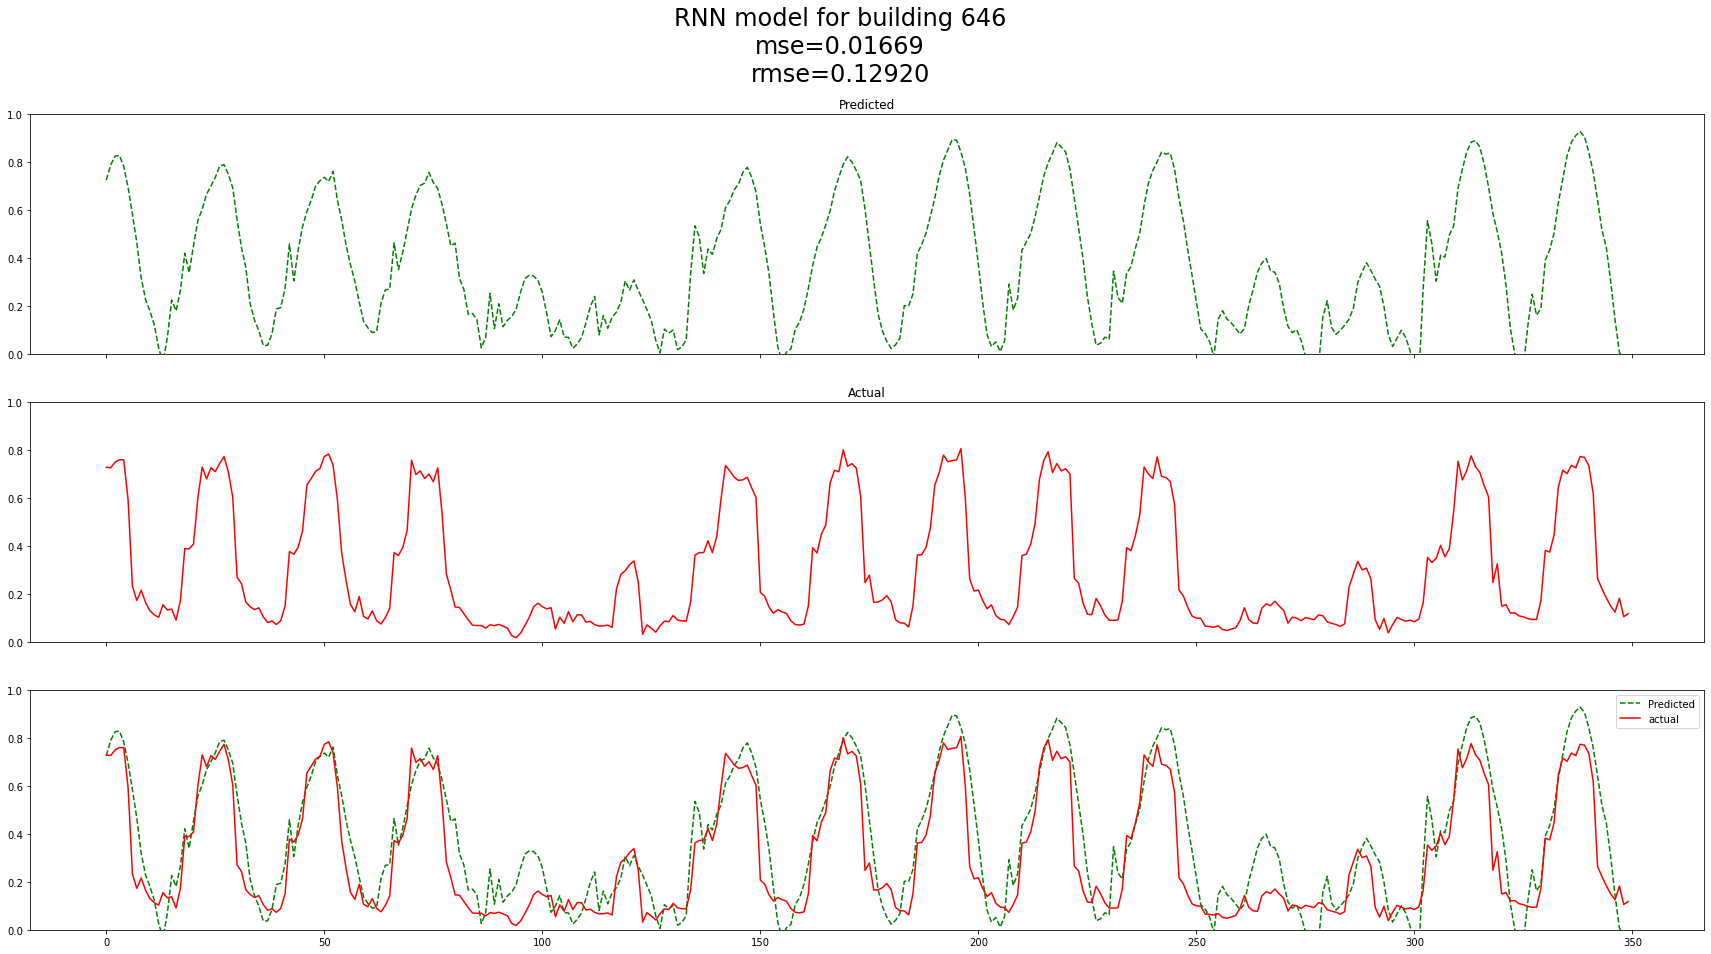

C:\Users\shomer\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\shomer\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\projects\Research-Buildings-Energy-forecasting-using-Deep-Learning\data_fetcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

model Transformer took 307.99786853790283 seconds


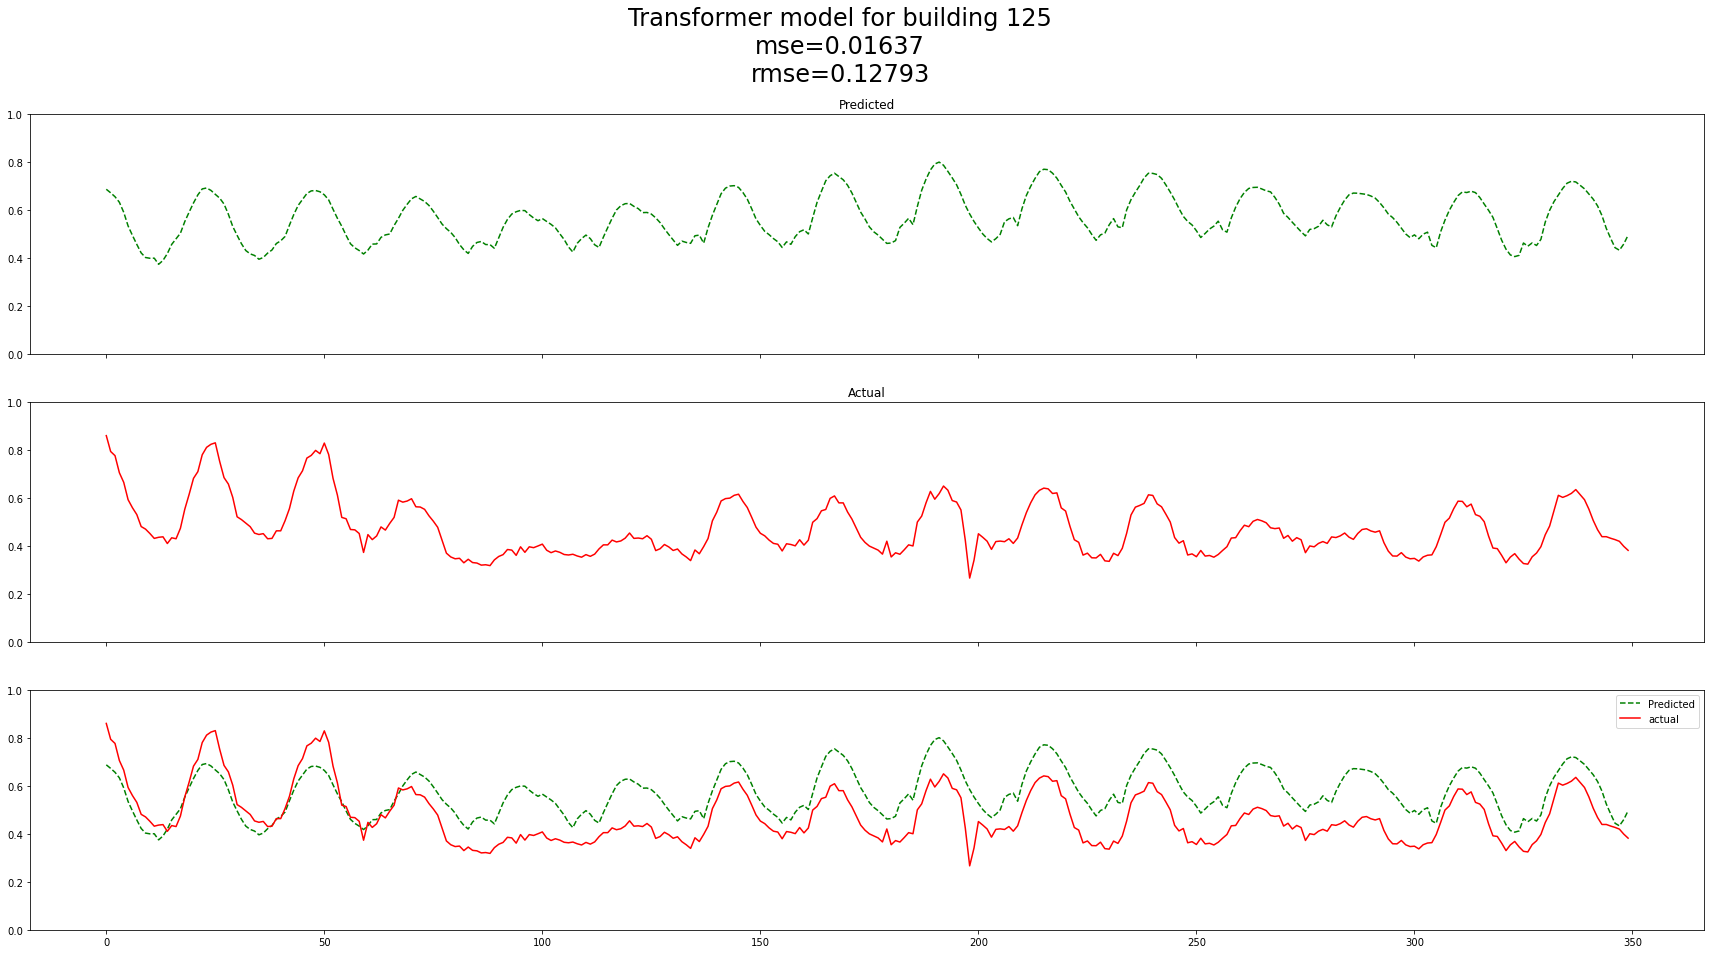

model GRU took 79.13084983825684 seconds


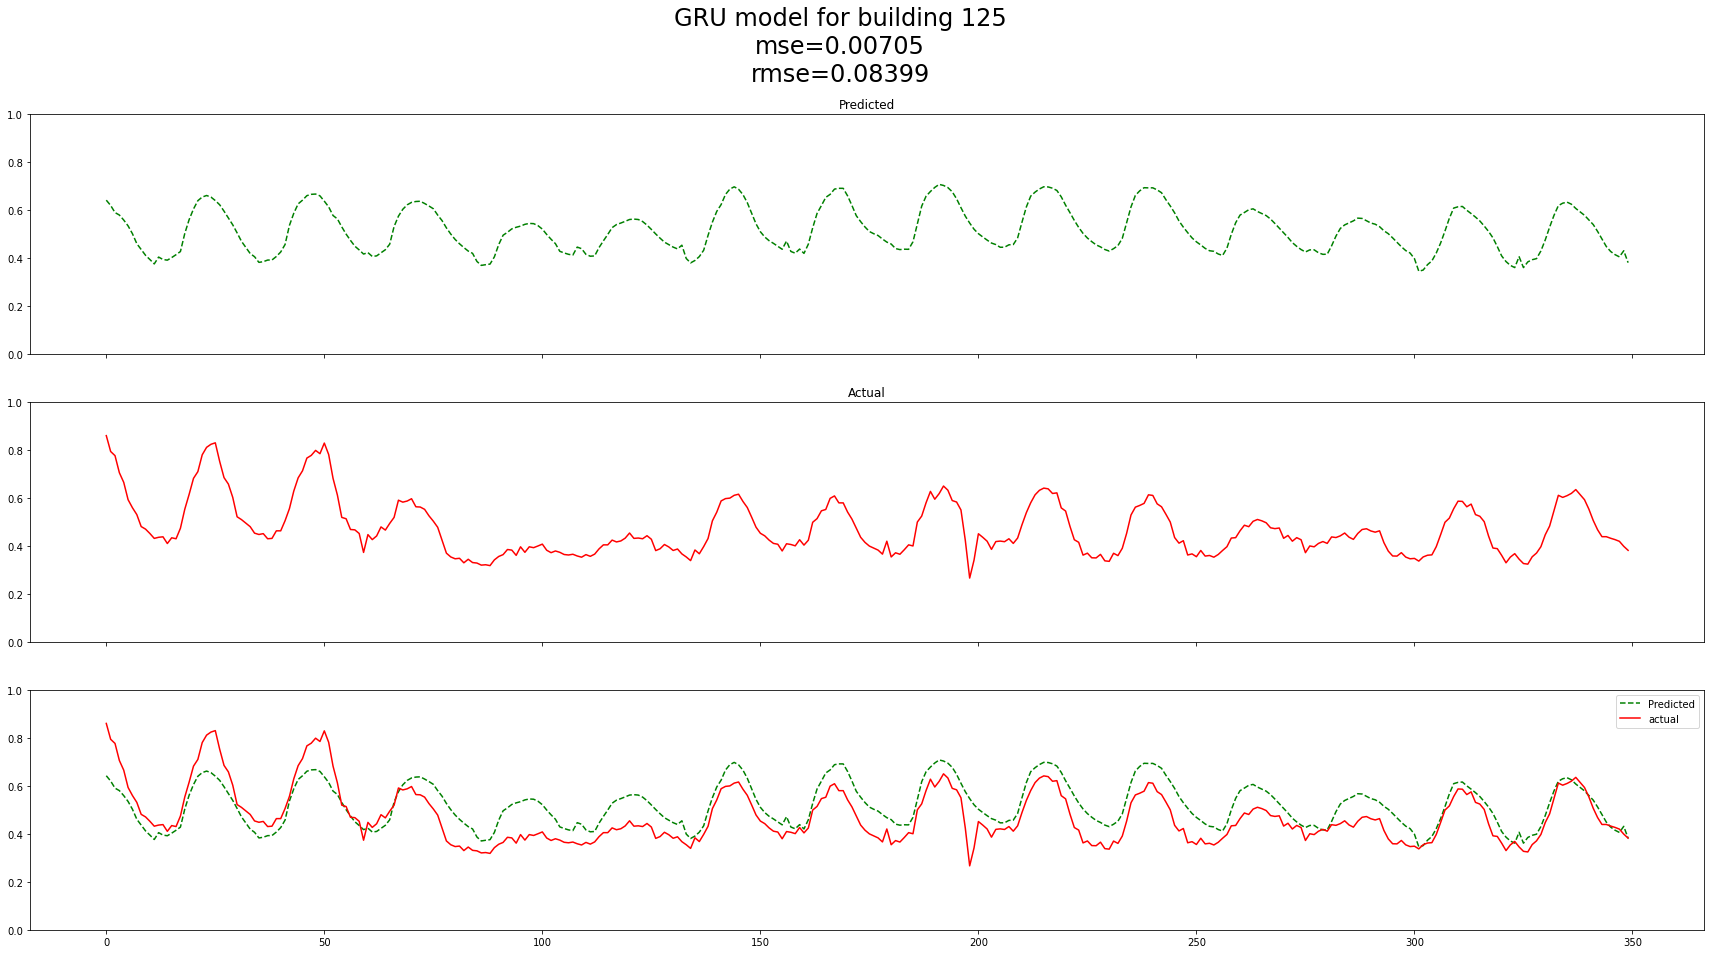

model LSTM took 93.26979327201843 seconds


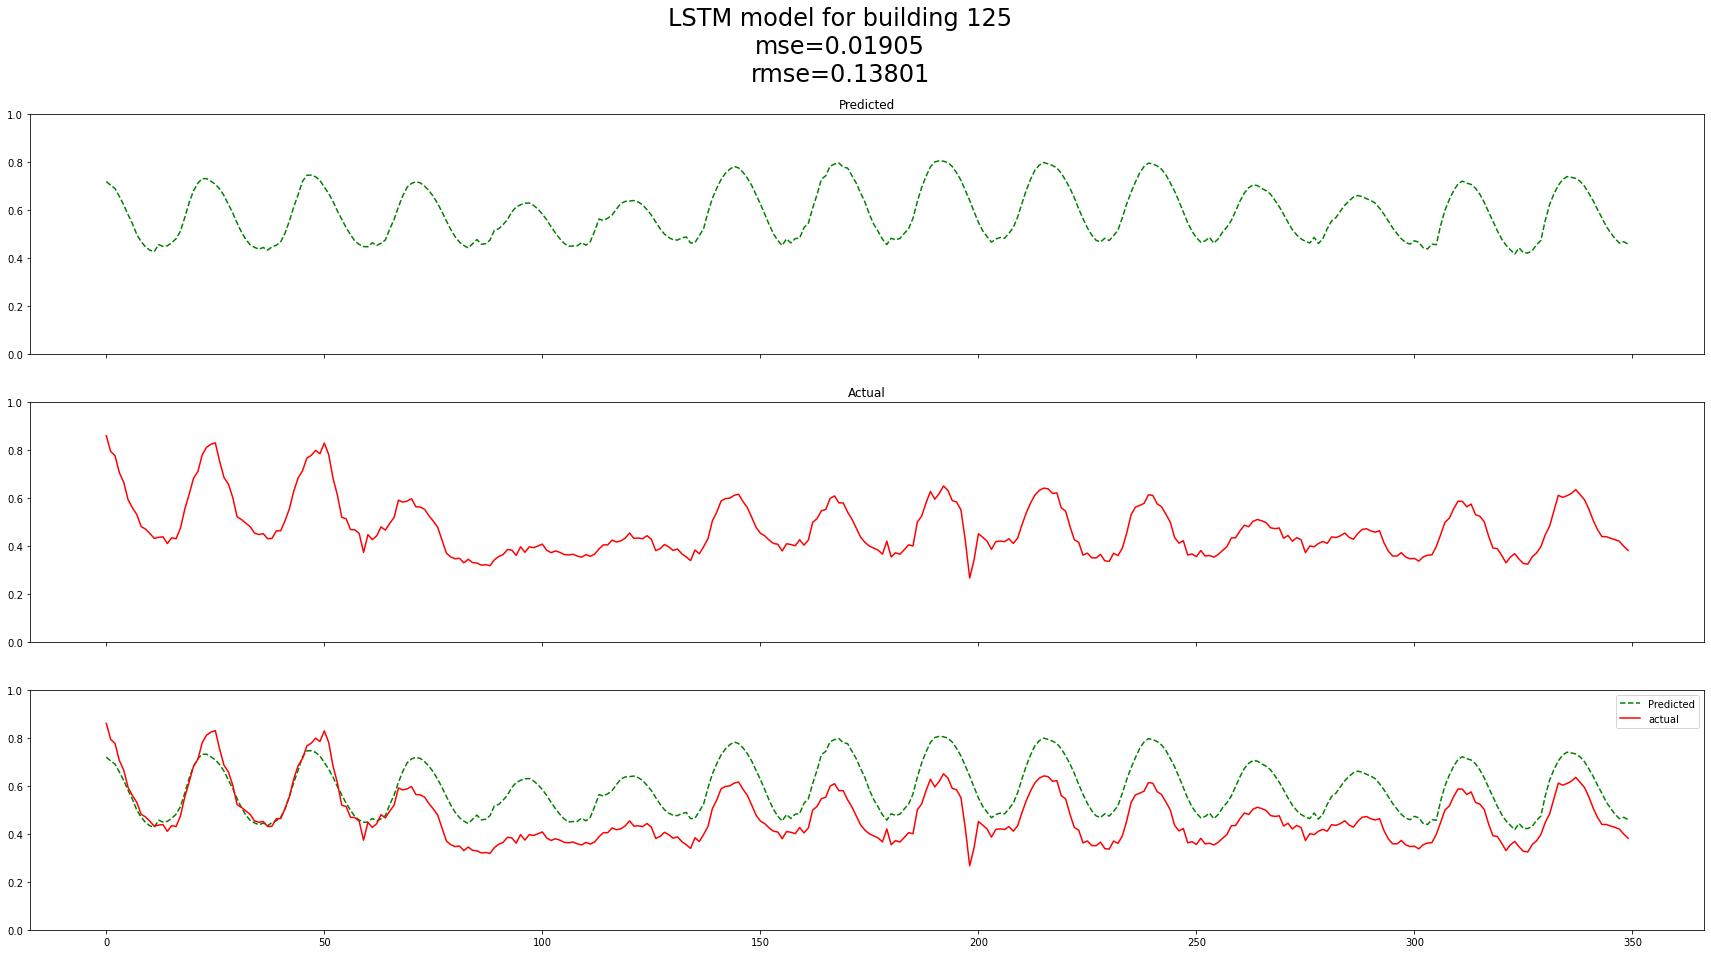

model RNN took 63.94894981384277 seconds


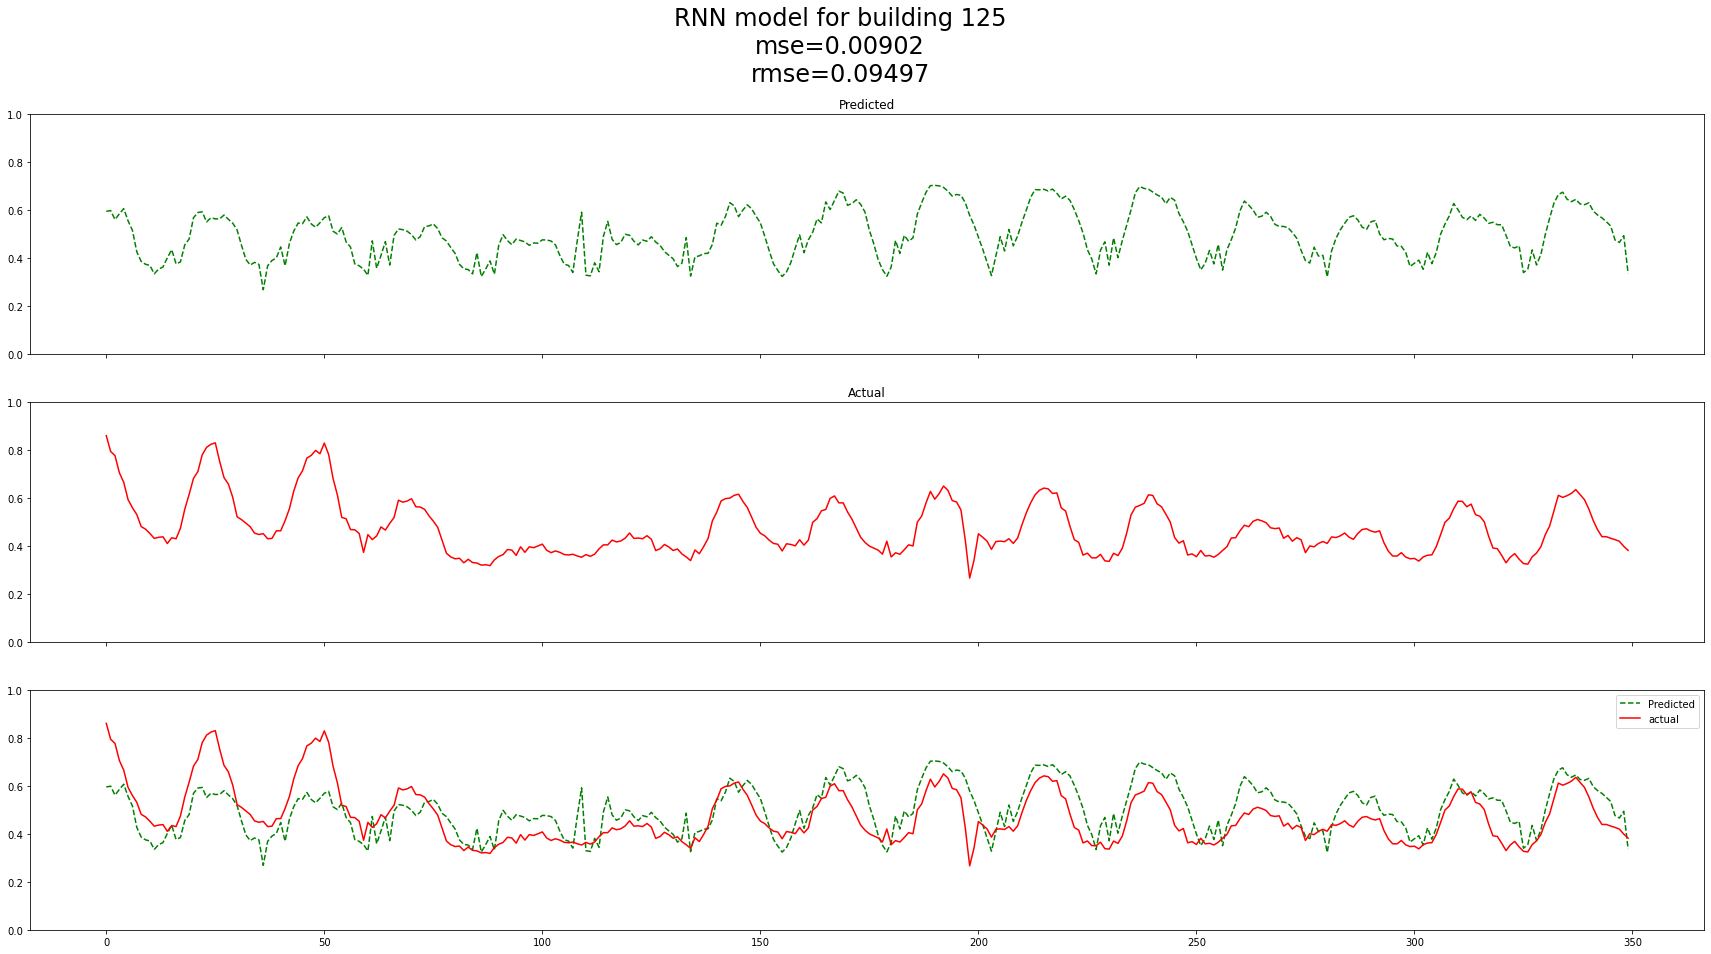

In [17]:
# %% loading models to evaluate them on new data
import time
models = ['models/Transformer_adam',
          'models/GRU_ADAM',
          'models/LSTM_ADAM',
          'models/RNN_ADAM']
finetuning_data = {}
for building_idx in b_id:
    train_gen, test_gen = loading_data(building_idx, 0.7)
    finetuning_data[building_idx] = {}
    for model_address in models:
        predicted = np.array([])
        actual = np.array([])
        cb = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=15,
                                              restore_best_weights=True)
        txt = model_address.split('/')[1].split('_')[0]

        finetuning_data[building_idx][txt] = []

        model = create_model(txt.lower())

        start_time = time.time()

        model.fit(train_gen,validation_data=test_gen, epochs=150,
                  verbose=False,
                  callbacks=[cb])
        time_taken = time.time() - start_time
        print(f"model {txt} took {time.time() - start_time} seconds")

        predicted = np.append(predicted, model.predict(test_gen[0]))
        actual = np.append(actual, test_gen[1])

        avg_mse = np.mean((actual - predicted)**2)
        avg_rmse = np.sqrt(np.mean((actual - predicted)**2))

        finetuning_data[building_idx][txt].append(
            (avg_mse, avg_rmse, time_taken))

        plot_output(actual, predicted, txt, building_idx, avg_mse, avg_rmse)

In [18]:
transformer, gru, lstm,rnn = [], [], [],[]
for building_idx in b_id:

    x, y, z,r = finetuning_data[building_idx].values()
    transformer.append(x)
    gru.append(y)
    lstm.append(z)
    rnn.append(r)
# %%
mse, rmse, t = [], [], []
for d in [transformer, gru, lstm,rnn]:
    for i in range(3):

        mse.append(d[i][0][0])
        rmse.append(d[i][0][1])
        t.append(d[i][0][2])

    d.append([np.mean(mse), np.mean(rmse), np.mean(t)])

# %%
for d, n in zip([transformer, gru, lstm,rnn], ['transformer', 'gru',
                                               'lstm','rnn']):
    print(f'--- {n} ---')
    print(' mse \t rmse \t time')
    print(f'{d[3][0]:0.4f}\t{d[3][1]:0.4f}\t{d[3][2]:0.4f}')

--- transformer ---
 mse 	 rmse 	 time
0.0088	0.0895	335.6760
--- gru ---
 mse 	 rmse 	 time
0.0073	0.0816	218.2669
--- lstm ---
 mse 	 rmse 	 time
0.0081	0.0852	187.8254
--- rnn ---
 mse 	 rmse 	 time
0.0088	0.0892	153.3368
